<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/5_trees_boosting_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación: Trees y Boosting

En aprendizaje de máquinas, la clasificación es el problema de identificar a qué clase (de un grupo finito de clases) una observación nueva pertenece, tomando como base un entrenamiento previo sobre un grupo de observaciones donde sí se conocían sus clases correspondientes. Los algoritmoas basados en árboles están dentro de los más utilizados en aprendizaje de máquinas por el buen rendimiento que alcanzan en la mayoría de las tareas.

In [1]:
import numpy as np # Biblioteca de álgebra lineal
import pandas as pd # Biblioteca de manejo de conjuntos de datos
import sklearn.tree # Implementación en sklearn del árbol de decisión
import matplotlib.pyplot as plt # Biblioteca de visualización
import sklearn.model_selection # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import sklearn.ensemble # Algoritmos basados en la combinación de estimadores débiles
import sklearn.linear_model # Algoritmos lineales como el Perceptron
import sklearn.preprocessing # Preprocesamiento de características

Utilizaremos un conjunto de datos que relaciona características fisiológicas de pacientes con la presencia de una enfermedad cardiovascular.

<img src="https://cfch.com.sg/wp-content/uploads/2024/11/Minimal-Residual-Disease-MRD_3-1.png" width="1000" height="400"></img>

<img src="https://www.netmeds.com/images/cms/wysiwyg/blog/2019/11/Angina_898X898.jpg" width="500" height="500"></img>

https://medium.com/data-science/heart-disease-uci-diagnosis-prediction-b1943ee835a7

In [2]:
cardiovascular_diseases = pd.read_csv("https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/cardiovascular_diseases.csv")
cardiovascular_diseases.head()

,age,male,chest_pain_type,resting_blood_pressure,cholesterol,high_fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_by_exercise,slope_st_by_excercise_peak,number_of_vessels_colored_by_flouroscopy,thalassemia,cardiovascular_disease
0,45,0,typical_angina,138,236,0,0,152,1,0.2,0,0,fixed_defect,1
1,61,1,typical_angina,120,260,0,1,140,1,3.6,0,1,reversable_defect,0
2,44,0,non_anginal_pain,108,141,0,1,175,0,0.6,0,0,fixed_defect,1
3,77,1,typical_angina,125,304,0,0,162,1,0.0,-1,3,fixed_defect,0
4,35,1,typical_angina,126,282,0,0,156,1,0.0,-1,0,reversable_defect,0


Separamos nuestro conjunto de datos en sus características y su etiqueta. A las características se les realiza una transformación One-Hot en donde las características discretas con un número `i` de categorías se les transforma en `i` características nuevas binarias. Esto es necesario, porque los algoritmos necesitan una representación estrictamente numérica de las características y este método no les asigna un número entero porque estas variables no tienen un orden ni valor numérico real. Por ejemplo si se tiene una característica con los valores

<img src="https://www.brainstobytes.com/content/images/2020/01/PokeData.png"></img>

y se le transforma utilizando One-Hot Encoding, se separan los tipos

<img src="https://www.brainstobytes.com/content/images/2020/01/PokeData2.png"></img>

Asi se ven las características discretas previas a la transformación.

In [3]:
cardiovascular_diseases[["chest_pain_type","thalassemia"]].head()

,chest_pain_type,thalassemia
0,typical_angina,fixed_defect
1,typical_angina,reversable_defect
2,non_anginal_pain,fixed_defect
3,typical_angina,fixed_defect
4,typical_angina,reversable_defect


In [5]:
cardiovascular_diseases["chest_pain_type"].unique()

array(['typical_angina', 'non_anginal_pain', 'asymptomatic',
       'atypical_angina'], dtype=object)

In [6]:
cardiovascular_diseases["thalassemia"].unique()

array(['fixed_defect', 'reversable_defect', 'normal'], dtype=object)

Con la función `pandas.get_dummies()` realizamos la transformación.

In [4]:
cardiovascular_diseases_features = pd.get_dummies(
    cardiovascular_diseases.iloc[:,:-1]
)
cardiovascular_diseases_label = cardiovascular_diseases.cardiovascular_disease
cardiovascular_diseases_features.iloc[:,-7:].head()

,chest_pain_type_asymptomatic,chest_pain_type_atypical_angina,chest_pain_type_non_anginal_pain,chest_pain_type_typical_angina,thalassemia_fixed_defect,thalassemia_normal,thalassemia_reversable_defect
0,False,False,False,True,True,False,False
1,False,False,False,True,False,False,True
2,False,False,True,False,True,False,False
3,False,False,False,True,True,False,False
4,False,False,False,True,False,False,True


Separamos nuestro conjunto de datos en un subconjunto de entrenamiento y prueba.

In [22]:
(cardiovascular_diseases_features_train, cardiovascular_diseases_features_test,
 cardiovascular_diseases_label_train, cardiovascular_diseases_label_test) = sklearn.model_selection.train_test_split(
    cardiovascular_diseases_features,
    cardiovascular_diseases_label,
    test_size=0.33,
    random_state=11)

## Decision Tree



En sklearn la implementación del árbol de decisión está en `sklearn.tree.DecisionTreeClassifier`

In [8]:
tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
    max_depth=3, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
    random_state = 11
    )
tree.fit( # Ajustamos nuestro árbol de decisión.
    cardiovascular_diseases_features_train,
    cardiovascular_diseases_label_train
)

DecisionTreeClassifier(max_depth=3, random_state=11)

Verificamos el rendimiento de nuestro árbol de decisión sobre nuestro subconjunto de prueba.

In [9]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    tree.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65        47
           1       0.69      0.68      0.69        53

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.67      0.67      0.67       100



Una de las ventajas más importantes de los árboles de decisión es la transparencia y explicabilidad del proceso de predicción. Podemos conocer claramente todas las decisiones tomadas por el clasificador y visualizarla en un árbol de decisión.

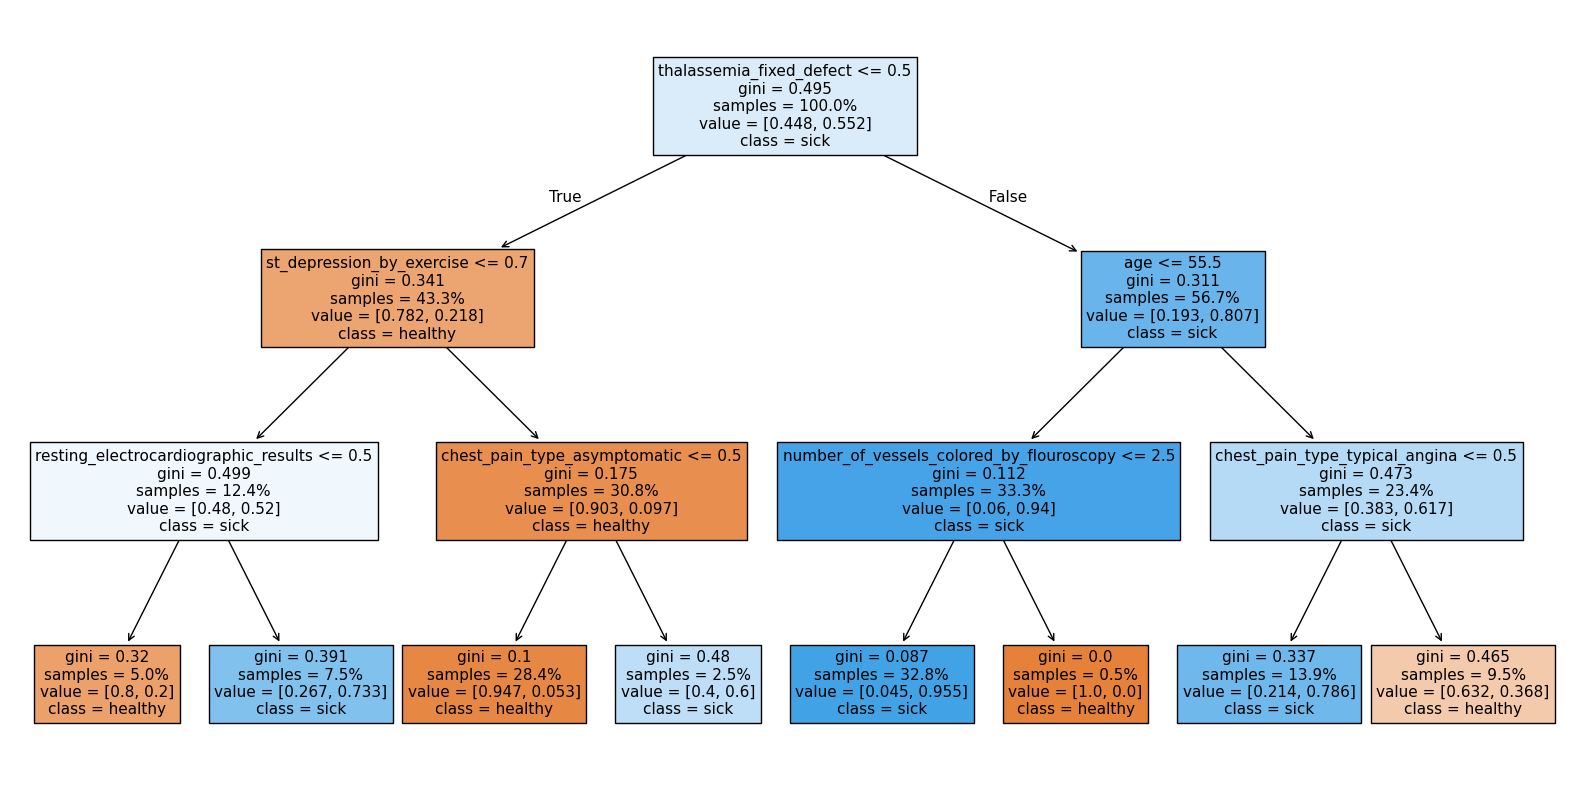

In [10]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = cardiovascular_diseases_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

### Actividad 1

Uno de los hiperparámetros de los árboles de decisión es la profundidad del mismo. Evalúa cómo se comporta su rendimiento al cambiar la profundidad del árbol.

In [ ]:
#Prográmame

## Random Forest

En Random Forest, cada árbol en el conjunto está construido desde una muestra del conjunto de entrenamiento.

In [11]:
random_forest = sklearn.ensemble.RandomForestClassifier(random_state = 11) # Instanciamos Random Forest.
random_forest.fit( # Ajustamos nuestro modelo.
    cardiovascular_diseases_features_train,
    cardiovascular_diseases_label_train
)

RandomForestClassifier(random_state=11)

Evaluamos el rendimiento de nuestro modelo y evidenciamos que es significativamente mayor que un árbol de decisión único.

In [12]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    random_forest.predict(cardiovascular_diseases_features_test)
))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        47
           1       0.80      0.83      0.81        53

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



Una de la información de inferencia que podemos extraer desde nuesto modelo entrenado es la lista de importancia de características, con la cual podemos conocer qué características son más importantes para el modelo.

In [13]:
feature_importance_list = pd.DataFrame(
    zip(cardiovascular_diseases.columns,
        random_forest.feature_importances_), # En este atributo está almacenada la lista de importancia de características.
    columns=["feature","importance"])
feature_importance_list.sort_values("importance",ascending=False)

,feature,importance
8,exercise_induced_angina,0.120717
6,resting_electrocardiographic_results,0.118239
0,age,0.093151
10,slope_st_by_excercise_peak,0.072617
3,resting_blood_pressure,0.072449
2,chest_pain_type,0.065066
9,st_depression_by_exercise,0.040547
7,maximum_heart_rate_achieved,0.032626
1,male,0.024686
5,high_fasting_blood_sugar,0.023107


<img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/50/f9/ICLH_Diagram_Batch_03_27-RandomForest.png"></img>

### Actividad 2

Random Forest es un conjunto de árboles de decisión independientes. Extrae uno de los árboles de decisión del conjunto y visualiza el grafo de decisión. Visita la documentación de Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [14]:
#Prográmame
random_tree = random_forest.estimators_[-1]

## Boosting

Boosting es la técnica de utilizar un conjunto de estimadores débiles para generar una predicción más robusta.

Cómo estimador débil utilizaremos un perceptrón, pero para ello primero necesitamos escalar nuestras características con `sklearn.preprocessing.RobustScaler()` debido a que este algoritmo es sensible a la escala de las variables.

In [15]:
# Escalamos las características
scaler = sklearn.preprocessing.RobustScaler()
cardiovascular_diseases_features_train_scaled = scaler.fit_transform(cardiovascular_diseases_features_train)
cardiovascular_diseases_features_test_scaled = scaler.transform(cardiovascular_diseases_features_test)

In [16]:
perceptron = sklearn.linear_model.Perceptron(random_state = 11, max_iter=10, fit_intercept=False)
perceptron.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

Perceptron(fit_intercept=False, max_iter=10, random_state=11)

Verificamos el rendimiento de nuestro perceptrón único.

In [17]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    perceptron.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        47
           1       0.77      0.81      0.79        53

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



Ahora ajustaremos un conjunto de perceptrones con `sklearn.ensemble.AdaBoostClassifier()`.

In [19]:
boosting = sklearn.ensemble.AdaBoostClassifier( # Istanciamos AdaBoost
    estimator = sklearn.linear_model.Perceptron(random_state = 11, max_iter=10, fit_intercept=False), # Utilizamos un perceptrón como estimador base.
    algorithm = "SAMME", # Utilizamos SAMME como algoritmo de boosting porque perceptrón no implementa el cálculo de probabilidades de predicción.
    n_estimators = 1000, # Nuestro conjunto tendrá 1000 estimadores débiles.
    random_state = 11,
    learning_rate = 0.1
)
boosting.fit(
    cardiovascular_diseases_features_train_scaled,
    cardiovascular_diseases_label_train
)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=Perceptron(fit_intercept=False, max_iter=10,
                                        random_state=11),
                   learning_rate=0.1, n_estimators=1000, random_state=11)

Verificamos que efectivamente mejoramos el rendimiento al utilizar un conjunto de estimadores débiles.

In [20]:
print(sklearn.metrics.classification_report(
    cardiovascular_diseases_label_test,
    boosting.predict(cardiovascular_diseases_features_test_scaled)
))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.85      0.85      0.85        53

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_adaboost_multiclass_001.png"></img>

### Actividad 3

Podemos utilizar boosting con cualquier estimador débil, este sólo debe comportarse mejor que el azar. Ajusta un conjunto de Support Vector Machines con kernel lineal con AdaBoost y verifica que funcione mejor que un estimador único.

In [ ]:
#Prográmame